In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [ ]:
import os
import pandas as pd

dataset = "Electronics_5.json"

if os.path.isfile(dataset):
    df = pd.read_json("Electronics_5.json", lines=True)
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

display(df.head(3))

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"


Veri boyutu 1689188 olduğu için COLAB kaldırmadı, bunun için veriler rasgele şekilde seçilerek 3 gruba ayrıldı.

In [ ]:
#Ayrılacak olan veriler shuffled olarak atandı
shuffled=df.sample(frac=1)

In [ ]:
#veriler rasgele bir şekilde karıştırıldı.
shuffled.tail(4)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
110225,A1CX9ISNOD26NS,B0002J1LDE,jpsoutlook,"[1, 1]",I have a 7.2 system. When I installed my seco...,5,Worth every penny,1367971200,"05 8, 2013"
251701,A1F2OJVMQG6EJI,B000K9DHZG,Joan L. Lovejoy,"[2, 2]",I read all the reviews for this product and de...,5,Athena iVoice Docking Sound System for IPOD,1221436800,"09 15, 2008"
575423,A24FXPXRPL17ZE,B0029NAQ7I,jray,"[0, 0]",My cannon powershot sd1100 camera fits perfect...,5,Cannon powershot fits perfectly,1265414400,"02 6, 2010"
1627103,A328S9RN3U5M68,B00DTZYHX4,Grady Harp,"[2, 2]",It is hard to believe that something so small ...,5,Small but powerful and sleek appearing adapter,1381276800,"10 9, 2013"


In [3]:
result=np.array_split(shuffled,3)

In [4]:
df1=result[0].reset_index().drop("index",axis=1)
#df2=result[1].reset_index().drop("index",axis=1)
#df3=result[2].reset_index().drop("index",axis=1)

In [ ]:
df1.shape

(563063, 9)

In [ ]:
df1.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HZOYH41J9PPA,B009SQQF9C,Iron Angel,"[1, 1]",Such a clever little machine. I'm learning abo...,5,The No-Risk Learning Tool,1386720000,"12 11, 2013"
1,A1ORZVQS8C1VVT,B0000VP1WQ,EcoActive,"[0, 0]",Excillent and built like a small tank! No prob...,5,Built like a tank!,1260057600,"12 6, 2009"


In [ ]:
#df2.head(2)

In [ ]:
#df3.head(2)

In [ ]:
df1.to_csv("amazon_1.csv")
#df2.to_csv("amazon_2.csv")
#df3.to_csv("amazon_3.csv")

In [5]:
#ilk olarak df1 üzerinden çalışma yapalım
df=pd.read_csv("amazon_1.csv").drop("Unnamed: 0",axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563063 entries, 0 to 563062
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      563063 non-null  object
 1   asin            563063 non-null  object
 2   reviewerName    554705 non-null  object
 3   helpful         563063 non-null  object
 4   reviewText      562694 non-null  object
 5   overall         563063 non-null  int64 
 6   summary         563055 non-null  object
 7   unixReviewTime  563063 non-null  int64 
 8   reviewTime      563063 non-null  object
dtypes: int64(2), object(7)
memory usage: 38.7+ MB


In [7]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HZOYH41J9PPA,B009SQQF9C,Iron Angel,"[1, 1]",Such a clever little machine. I'm learning abo...,5,The No-Risk Learning Tool,1386720000,"12 11, 2013"
1,A1ORZVQS8C1VVT,B0000VP1WQ,EcoActive,"[0, 0]",Excillent and built like a small tank! No prob...,5,Built like a tank!,1260057600,"12 6, 2009"


In [8]:
df.drop(["reviewerID","asin","reviewerName","helpful","summary","unixReviewTime","reviewTime"],axis=1,inplace=True)

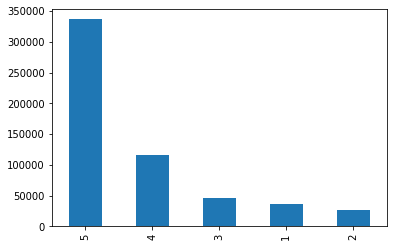

In [9]:
df.overall.value_counts().plot.bar()

reviewText verilerinden noktalama, digit ve satır sonu'larını kadlıralım

In [10]:
df["reviewText"]=df["reviewText"].str.lower() #küçük harfe çevrildi
df["reviewText"]=df["reviewText"].str.replace("[^\w\s]","") #noktalama işaretlerini kaldırır
df["reviewText"]=df["reviewText"].str.replace("\d+","") #d digit rakamları kaldırır
df["reviewText"]=df["reviewText"].str.replace("\n"," ").replace("\r","") #Satır sonu,\n enter a basılmışsa \r

In [11]:
df.loc[df["overall"]==3,"sentimentOverall"]="neutral"
df.loc[df["overall"]<3,"sentimentOverall"]="negative"
df.loc[df["overall"]>3,"sentimentOverall"]="positive"

In [12]:
df.sample(3)

,reviewText,overall,sentimentOverall
8070,ive worked as a computer tech support consulta...,1,negative
173551,these cables are a lot thinner than most howev...,5,positive
392440,i ordered the poetic tn asus transformer prime...,5,positive


In [13]:
df["reviewText"][0]

'such a clever little machine im learning about operating system design and this is the best platform to try out some zany tricks without worrying about your main rig we should definitely have one of these instead of a textbook in computer science there are lots of distributions for the nontechnical too this is really built for everyone to enjoy'

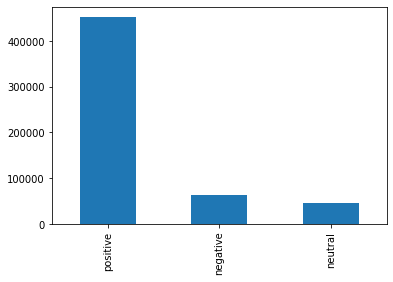

In [14]:
df["sentimentOverall"].value_counts().plot.bar()

In [15]:
#reviewText alanında boşluklar olduğu için o alanlar kaldırıldı
df=df[df.reviewText.notna()]

In [16]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer=TreebankWordTokenizer()
df['tokenized']=[tokenizer.tokenize(str(i)) for i in df['reviewText'].values]

In [17]:
!pip install nltk

In [18]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
#Ram i çok harcadığından çıkarttım.
#from nltk.stem import WordNetLemmatizer
#lemmatizer=WordNetLemmatizer()
#df['lemmatize']=[[lemmatizer.lemmatize(i) for i in words] for words in df['reviewText'].values]

In [20]:
from textblob import TextBlob
df[["polarity","subjectivity"]]=df["reviewText"].apply(lambda t:pd.Series(TextBlob(t).sentiment))

In [21]:
df.loc[df['subjectivity']>0.5,'sentimentPolarity']="positive" #positive
df.loc[df['subjectivity']==0.5,'sentimentPolarity']="neutral" #neutral
df.loc[df['subjectivity']<0.5,'sentimentPolarity']="negative" #negative
df.head()

,reviewText,overall,sentimentOverall,tokenized,polarity,subjectivity,sentimentPolarity
0,such a clever little machine im learning about...,5,positive,"[such, a, clever, little, machine, im, learnin...",0.218229,0.458333,negative
1,excillent and built like a small tank no probl...,5,positive,"[excillent, and, built, like, a, small, tank, ...",-0.250000,0.400000,negative
2,i like this much better than the thumb drive r...,5,positive,"[i, like, this, much, better, than, the, thumb...",0.172857,0.541429,positive
3,i might have my hard drive further from my mac...,3,neutral,"[i, might, have, my, hard, drive, further, fro...",0.015000,0.488333,negative
4,the mhl cable is quite long but the cable that...,4,positive,"[the, mhl, cable, is, quite, long, but, the, c...",0.077976,0.386310,negative


In [22]:
#ram konusunda sıkıntı olduğu için sistem kesintisi olduğunda bu df ile devam edileccek, önceki kodları çalıştırmaya gerek kalmayacaktır
df.to_csv("result_df.csv")

In [4]:
df=pd.read_csv("result_df.csv")

In [5]:
df=df.drop("Unnamed: 0",axis=1)

In [6]:
df.sample()

,reviewText,overall,sentimentOverall,tokenized,polarity,subjectivity,sentimentPolarity
224725,great camera and amazing video quality follow...,5,positive,"['great', 'camera', 'and', 'amazing', 'video',...",0.285417,0.5,neutral


sentimentOverall ve sentimentPolarity tabloları listelendi, verilen yıldızlar ile kelimelerin sentiment analizi arasında fazla olmasa da fark gözlendi.
Farkın nedenini kötü yorum yazıp 4-5 yıldız verenler veya iyi yorum yazıp 1-2 puan verenler olduğu düşünüldü.

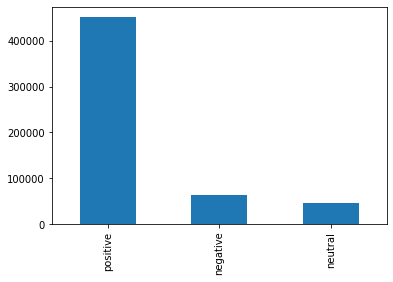

In [26]:
df["sentimentOverall"].value_counts().plot(kind="bar")

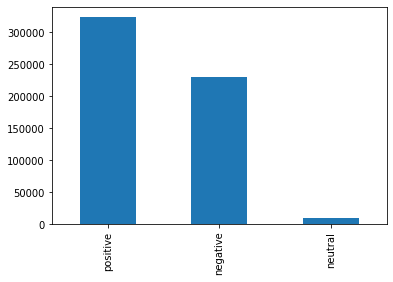

In [27]:
df["sentimentPolarity"].value_counts().plot(kind="bar")

Verilen değerlendirme puanları ve yapılan yorumların sentiment analizi farkları listesi

In [28]:
df[["sentimentOverall","sentimentPolarity"]]

,sentimentOverall,sentimentPolarity
0,positive,negative
1,positive,negative
2,positive,positive
3,neutral,negative
4,positive,negative
...,...,...
562689,positive,negative
562690,positive,negative
562691,neutral,positive
562692,positive,positive


In [5]:
pip install wordcloud

In [6]:
from wordcloud import WordCloud

In [7]:
def wc(data,bgcolor):
    from PIL import Image
    mask = np.array(Image.open("star.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=200).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [8]:
possitive_data_overall_sentiment=df[df["sentimentOverall"]=="positive"]["reviewText"]
negative_data_overall_sentiment=df[df["sentimentOverall"]=="negative"]["reviewText"]
neutral_data_overall_sentiment=df[df["sentimentOverall"]=="neutral"]["reviewText"]

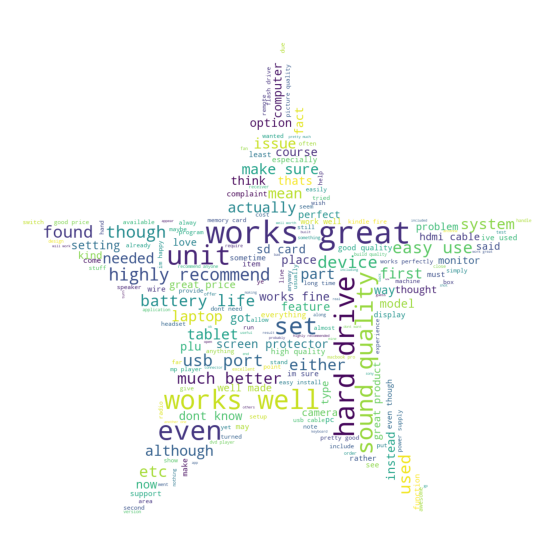

In [9]:
wc(possitive_data_overall_sentiment,"white")

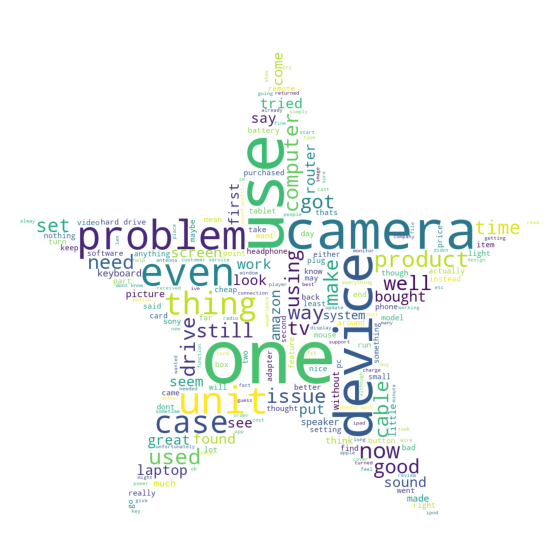

In [10]:
wc(negative_data_overall_sentiment,"white")

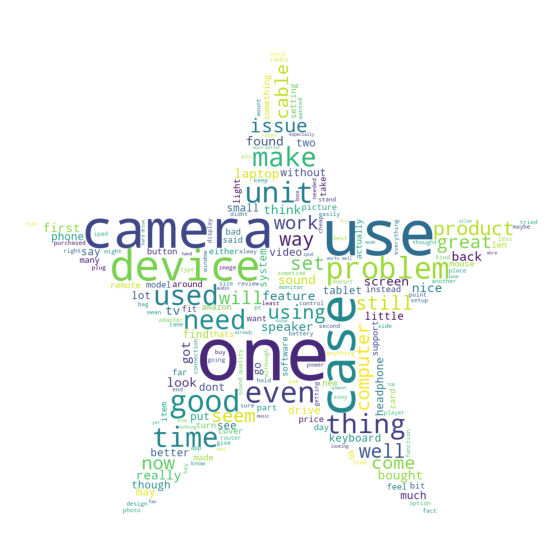

In [11]:
wc(neutral_data_overall_sentiment,"white")

In [12]:
def wc(data,bgcolor):
    from PIL import Image
    mask = np.array(Image.open("user.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=200).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [13]:
possitive_data_overall_polarity=df[df["sentimentPolarity"]=="positive"]["reviewText"]
negative_data_overall_polarity=df[df["sentimentPolarity"]=="negative"]["reviewText"]
neutral_data_overall_polarity=df[df["sentimentPolarity"]=="neutral"]["reviewText"]

Polarity Interpretations

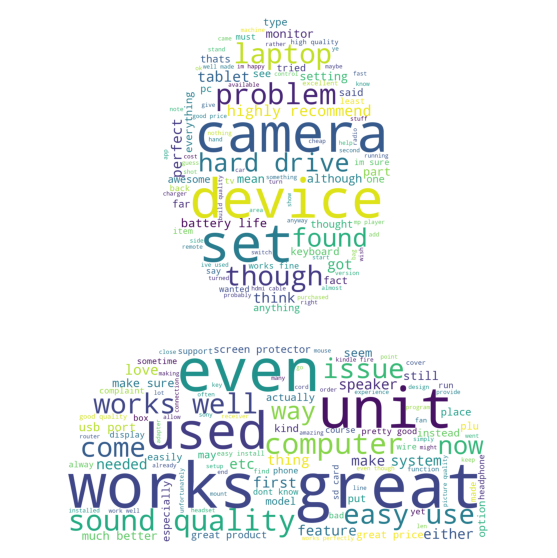

In [14]:
wc(possitive_data_overall_polarity,"white")

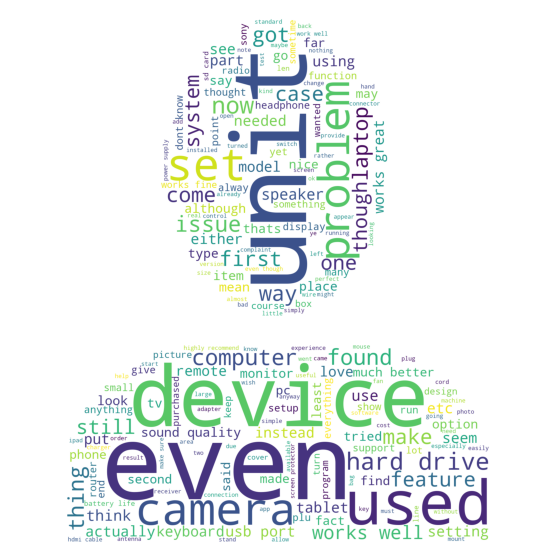

In [15]:
wc(negative_data_overall_polarity,"white")

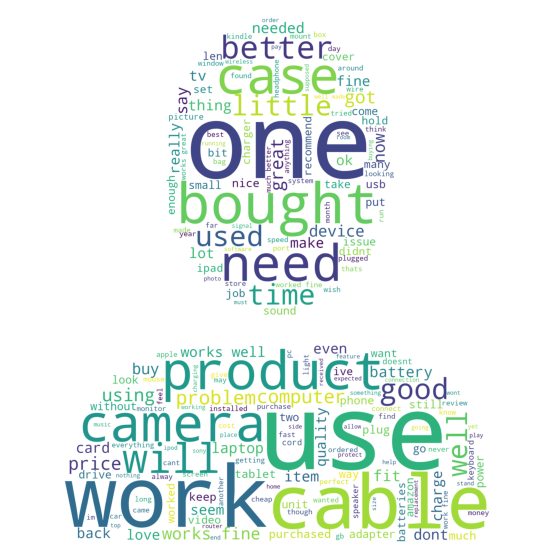

In [16]:
wc(neutral_data_overall_polarity,"white")

Overall'e göre classification işlemi yapalım

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
df.overall=df.overall.astype("category")

In [9]:
x,y=df['reviewText'],df['sentimentOverall']

In [10]:
x.shape,y.shape

((562694,), (562694,))

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=60)

In [12]:
x_train

262317    bought three and either they didnt work at all...
141798    i bought this tv after much comparing in early...
215776    my mac battery died on my macbook pro a few da...
171396    this cable works great on my razr maxx well bu...
18593     my old battery pack broke and i needed a repla...
                                ...                        
260257    this is my first pda in a few years and althou...
327569    it really is  feet long which is nice if your ...
456825    my daughter uses this case for school everyday...
174179    this is a great home computer  we are very hap...
395469    you have to adjust the levels but once you do ...
Name: reviewText, Length: 422020, dtype: object

In [13]:
x_test

213879    my new home is wired for ethernet but most roo...
141133    fits the ipad mini retina display very well be...
431845    got it from lightening then after analyzing th...
141810    remote will not work until tv is warmed up for...
63809     works well with my harmon kardon avr  w per ch...
                                ...                        
46997     does exactly what i got it for a longer usb co...
331235    everything was fine with this product it works...
380750    i have bought it with my replacement of my  co...
534355    works prefect for my paypal here connecting to...
369099    i bought recently a sony w camera and it uses ...
Name: reviewText, Length: 140674, dtype: object

In [14]:
y_train

262317    negative
141798    positive
215776    positive
171396    positive
18593     positive
            ...   
260257    positive
327569    positive
456825    positive
174179    positive
395469    positive
Name: sentimentOverall, Length: 422020, dtype: object

In [15]:
y_test

213879    positive
141133    positive
431845    negative
141810    negative
63809     positive
            ...   
46997     positive
331235    positive
380750    positive
534355    positive
369099    positive
Name: sentimentOverall, Length: 140674, dtype: object

In [16]:
vect=CountVectorizer()
x_train_dtm=vect.fit_transform(x_train,y_train)
x_test_dtm=vect.transform(x_test)

In [17]:
x_train_dtm.shape,x_test_dtm.shape

((422020, 487660), (140674, 487660))

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [29]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
#pip list

In [19]:
b=MultinomialNB()
model=b.fit(x_train_dtm,y_train)
b_predict=b.predict(x_test_dtm)

In [20]:
accuracy_score(y_test,b_predict)

0.8381150745695722

Model kullanılmak için kaydededildi

In [33]:
#Model oluşturduğumuzda CountVectorizer yapabilmek için bu alanın da modelle birlikte alınması gerekir.
vocab = vect.vocabulary_

In [34]:
import pickle
pickle.dump(model, open('NLP.pkl', 'wb'))
pickle.dump(vocab, open('Vocab.pkl', 'wb'))

Eğittiğimiz modelimizi bir web sayfasına yerleştirerek, kullanıcılardan yorum aldık ve yorumları sentiment analizi(bu datasette sentimentOverall olarak işledik) yaparak sonuçları görmeye çalıştık.


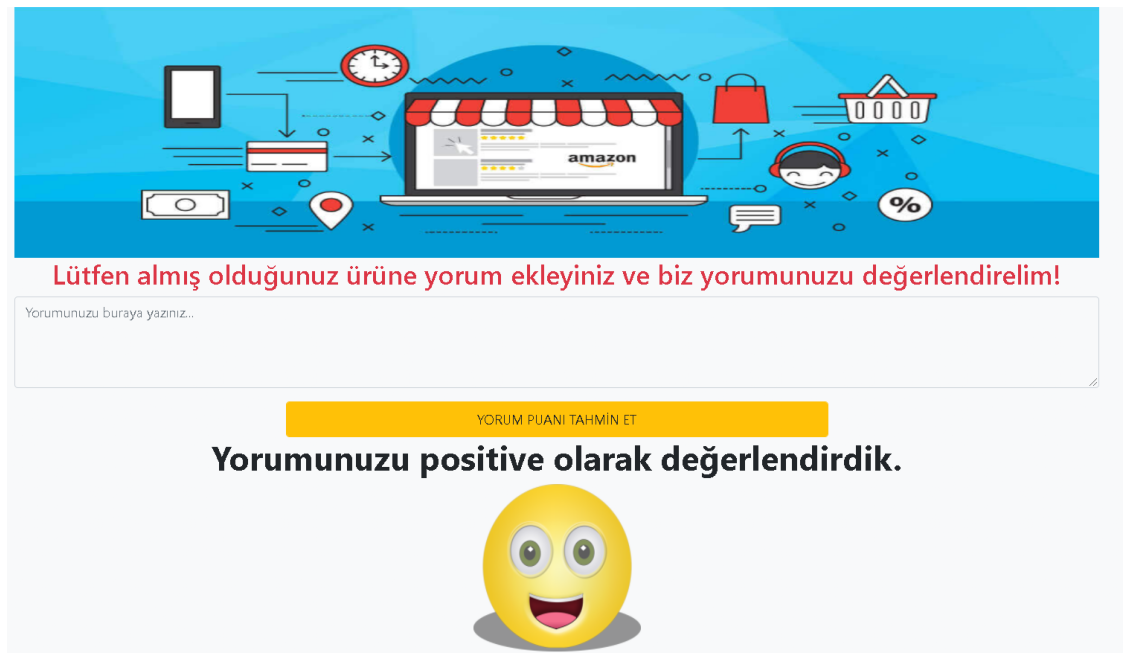

In [21]:
plt.figure(figsize=(20,20))
img=plt.imread('positive image.PNG')
plt.imshow(img)
plt.axis('off')
plt.show()

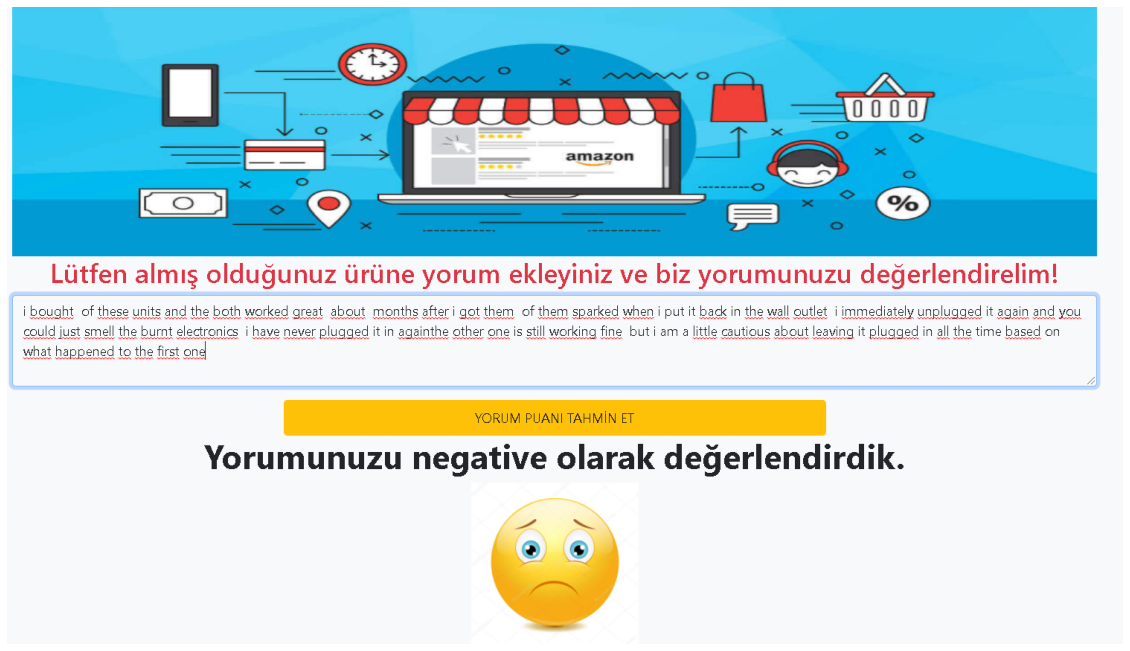

In [22]:
plt.figure(figsize=(20,20))
img=plt.imread('Negative image.PNG')
plt.imshow(img)
plt.axis('off')
plt.show()

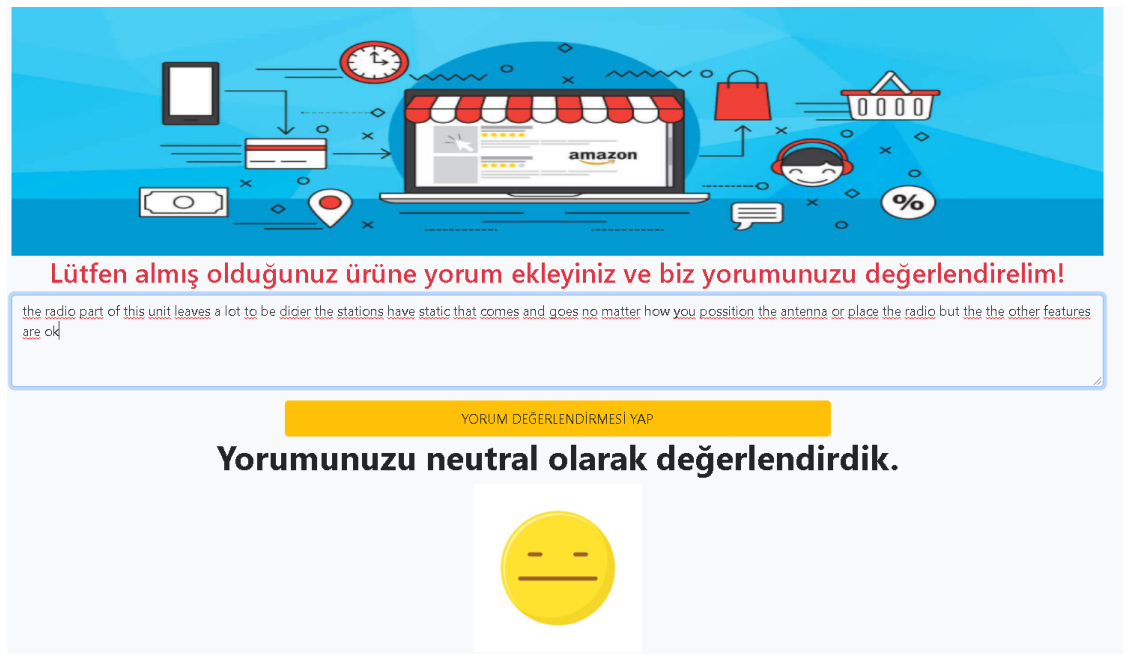

In [41]:
plt.figure(figsize=(20,20))
img=plt.imread('neutral image.PNG')
plt.imshow(img)
plt.axis('off')
plt.show()